# MNIST 데이터를 VE와 VAE로 학습해보기


## Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


Let's also create a separate encoder model:

In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## Load Data

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 3s 0us/step


We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Training

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.3677 - val_loss: 0.2722
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2659 - val_loss: 0.2562
Epoch 3/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.2450 - val_loss: 0.2316
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2232 - val_loss: 0.2127
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.2074 - val_loss: 0.1997
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1967 - val_loss: 0.1910
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1889 - val_loss: 0.1840
Epoch 8/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1823 - val_loss: 0.1778
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.1764 - val_loss: 0.1722
Epoch

## Visualize

We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [0]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

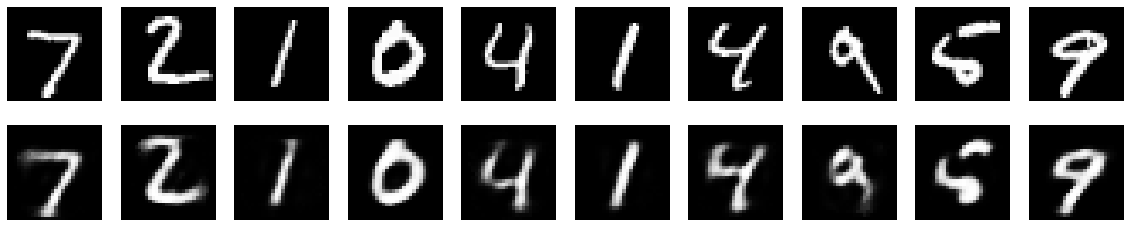

In [11]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional autoencoder

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [26]:
! tensorboard --logdir=/tmp/autoencoder


TensorBoard 1.10.0 at http://27bd3856687f:6006 (Press CTRL+C to quit)


In [27]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 149us/step - loss: 0.2134 - val_loss: 0.1621
Epoch 2/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.1535 - val_loss: 0.1450
Epoch 3/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.1386 - val_loss: 0.1290
Epoch 4/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.1309 - val_loss: 0.1237
Epoch 5/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.1259 - val_loss: 0.1230
Epoch 6/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.1220 - val_loss: 0.1217
Epoch 7/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.1192 - val_loss: 0.1200
Epoch 8/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.1168 - val_loss: 0.1189
Epoch 9/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.1154 - val_loss: 0.1

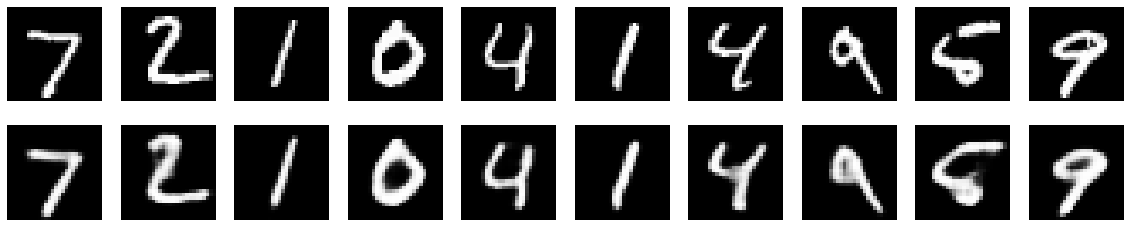

In [40]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [38]:
encoded_imgs[i].shape

(784,)

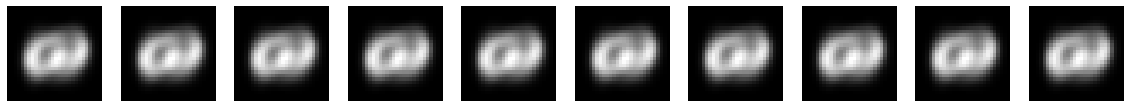

In [41]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(28, 28).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Application to image denoising

In [0]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

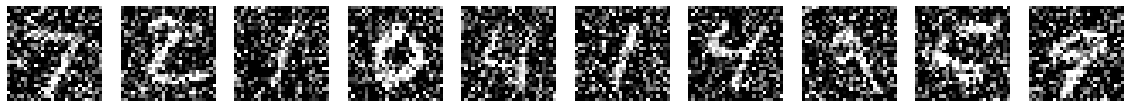

In [59]:

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [0]:
encoder = Model(input_img, encoded)

In [0]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 138us/step - loss: 0.1806 - val_loss: 0.1242
Epoch 2/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.1198 - val_loss: 0.1130
Epoch 3/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.1120 - val_loss: 0.1081
Epoch 4/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.1080 - val_loss: 0.1082
Epoch 5/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.1057 - val_loss: 0.1056
Epoch 6/100
60000/60000 [==============================] - 8s 133us/step - loss: 0.1041 - val_loss: 0.1066
Epoch 7/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.1031 - val_loss: 0.1008
Epoch 8/100
60000/60000 [==============================] - 8s 132us/step - loss: 0.1022 - val_loss: 0.1016
Epoch 9/100
60000/60000 [==============================] - 8s 131us/step - loss: 0.1015 - val_

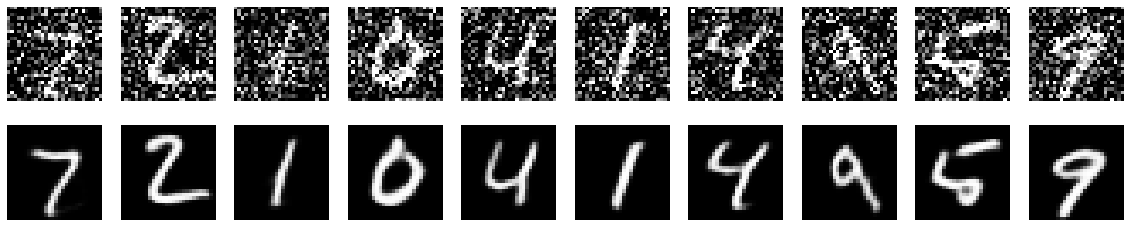

In [55]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [57]:
encoded_imgs = encoded.predict(x_test_noisy)
encoder_img.shape

AttributeError: ignored

## 참고사이트

참고 사이트 : https://blog.keras.io/building-autoencoders-in-keras.html